In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import src.database as db

# Load the rushing data from the database

In [47]:
query = """with rushing_cte as (
            SELECT
                player,
                position,
                age,
                week,
                season,
                rushing_attempts,
                rushing_yards,
                rushing_TD,
                (rushing_yards * 0.1) + (rushing_TD * 6) as fPTS,
                MIN(season) over (PARTITION BY player) as first_season
            FROM
                rushing
            ) 
            SELECT
                player,
                age,
                week,
                season,
                fPTS,
                AVG(fPTS) over (PARTITION BY player ORDER BY season, week ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) as fPTS_short_rolling_average,
                AVG(fPTS) over (PARTITION BY player ORDER BY season, week ROWS BETWEEN 24 PRECEDING AND CURRENT ROW) as fPTS_long_rolling_average,
                SUM(rushing_attempts) over (PARTITION BY player ORDER BY season, week) as cum_rush_attempts,
                COUNT(week) over (PARTITION BY player ORDER BY season, week) as cum_games_played
            FROM rushing_cte
            WHERE first_season > 2000 AND position = 'RB'
            ORDER BY fPTS_short_rolling_average DESC
"""
conn = db.create_connection('./data/football_stats.db')
df = pd.read_sql(query,conn)
df = df[df.cum_games_played > 24] 
conn.close()
df.head()

,player,age,week,season,fPTS,fPTS_short_rolling_average,fPTS_long_rolling_average,cum_rush_attempts,cum_games_played
0,LaDainian Tomlinson,27.504,16,2006,12.3,28.177778,18.876,2034,94
1,LaDainian Tomlinson,27.485,15,2006,31.9,27.544444,19.184,2012,93
2,LaDainian Tomlinson,27.466,14,2006,28.3,27.455556,18.396,1987,92
4,Larry Johnson,26.118,17,2005,38.1,25.677778,16.628,476,29
5,LaDainian Tomlinson,27.523,17,2006,6.6,25.544444,19.112,2050,95


In [48]:
# Compare the short term rolling average (last 10 games)
# to the long term rolling average
df['short_versus_long_rolling'] = df.fPTS_short_rolling_average / df.fPTS_long_rolling_average

# Compare the short term rolling average to the max of the long term rolling average
max_long_rolling = df.groupby('player')['fPTS_long_rolling_average'].max().to_dict()
df['short_versus_max_long_rolling'] = df.fPTS_short_rolling_average / df.player.map(max_long_rolling)

In [49]:
# add bins to cumulative touches
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 5000]
df["touches_bin"] = pd.cut(df["cum_rush_attempts"], bins=bins)
df.head()

,player,age,week,season,fPTS,fPTS_short_rolling_average,fPTS_long_rolling_average,cum_rush_attempts,cum_games_played,short_versus_long_rolling,short_versus_max_long_rolling,touches_bin
0,LaDainian Tomlinson,27.504,16,2006,12.3,28.177778,18.876,2034,94,1.492783,1.426578,"(2000, 2500]"
1,LaDainian Tomlinson,27.485,15,2006,31.9,27.544444,19.184,2012,93,1.435803,1.394514,"(2000, 2500]"
2,LaDainian Tomlinson,27.466,14,2006,28.3,27.455556,18.396,1987,92,1.492474,1.390014,"(1500, 2000]"
4,Larry Johnson,26.118,17,2005,38.1,25.677778,16.628,476,29,1.544249,1.253798,"(0, 500]"
5,LaDainian Tomlinson,27.523,17,2006,6.6,25.544444,19.112,2050,95,1.336566,1.293259,"(2000, 2500]"


# Visualize

<AxesSubplot:xlabel='cum_rush_attempts', ylabel='short_versus_long_rolling'>

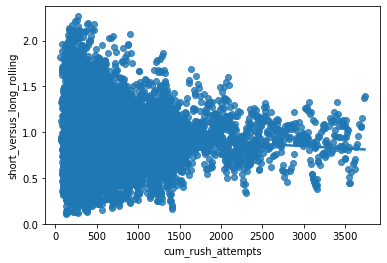

In [50]:
sns.regplot(x='cum_rush_attempts', y='short_versus_long_rolling', data=df)

<AxesSubplot:xlabel='touches_bin', ylabel='short_versus_long_rolling'>

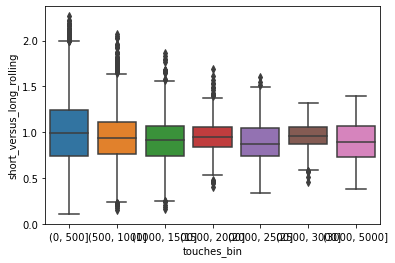

In [51]:
sns.boxplot(x='touches_bin', y='short_versus_long_rolling', data=df)

<AxesSubplot:xlabel='cum_rush_attempts', ylabel='short_versus_max_long_rolling'>

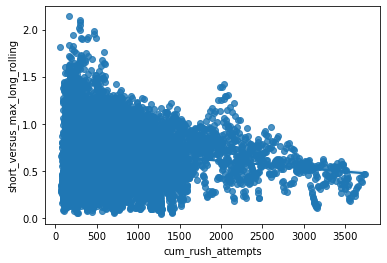

In [52]:
sns.regplot(x='cum_rush_attempts', y='short_versus_max_long_rolling', data=df)

<AxesSubplot:xlabel='touches_bin', ylabel='short_versus_max_long_rolling'>

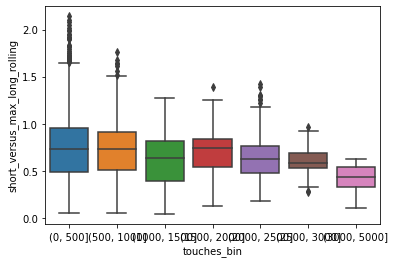

In [53]:
sns.boxplot(x='touches_bin', y='short_versus_max_long_rolling', data=df)